In [ ]:
image = cv2.imread("/Users/gaky/Desktop/efir/photo/M0006/sort/fa31f05b-88dc-43e6-a70e-a8043ddf2807.jpg")

down_width = 400
down_height = 220
down_points = (down_width, down_height)
resized_down = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)
resized_down = cv2.cvtColor(resized_down, cv2.COLOR_BGR2RGB)
 
# let's upscale the image using new 

In [112]:
import os
import cv2


def test_shit(folder):
    sick = []
    images = os.listdir(folder)
    for i in images:
        if i == ".DS_Store":
            images.remove(i)
    
    for i in images:
        image = cv2.imread(folder+"/"+i)

        down_width = 400
        down_height = 220
        down_points = (down_width, down_height)
        resized_down = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)
        resized_down = cv2.cvtColor(resized_down, cv2.COLOR_BGR2RGB)
        
        im = np.array(resized_down)
        im_clone = im
        im = np.transpose(im, (2, 0, 1))
        im = torch.tensor(im)
        im = im/255.
        
        with torch.no_grad():
            model.eval()
            out = model(im.float().unsqueeze(0))
            out = torch.argmax(out, dim=1)
            #print(out)
            #print(im.shape)
            if out == 0:
                sick.append(folder+"/"+i)
                #print(folder+"/"+i)
    return sick

In [113]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
epochs = 2000
image_size = (300, 500)
batch_size = 16
learning_rate = 0.0001
momentum = 0.2

In [114]:
#Data preparation
class CustomImageDataset(Dataset):
    def __init__(self, labels_arr, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.DataFrame(labels_arr)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = torch.tensor(int(self.img_labels.iloc[idx, 1]))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
    
def create_dataset(folder, label):
    files = os.listdir(folder)
    for i in files:
        if i =='.DS_Store':
            files.remove(i)
    files = np.array(files)
    labels_arr = np.zeros(len(files), dtype=np.uint8)
    labels_arr.fill(label)
    labels_arr = np.column_stack((files, labels_arr))

    transform = transforms.Compose([transforms.Resize(image_size)])
    dataset = CustomImageDataset(labels_arr, folder, transform=transform)
    return dataset


#pure train datasets
dataset_on = create_dataset("/Users/gaky/Desktop/efir/all simple on's/on", int(0))
dataset_low = create_dataset("/Users/gaky/Desktop/efir/on hard on's/final low on", int(0))
dataset_off = create_dataset("/Users/gaky/Desktop/efir/off for use/off mix", int(1))
dataset_night = create_dataset("/Users/gaky/Desktop/efir/off for use/off night", int(2))


#agmented train datasets
dataset_off_changed = create_dataset("/Users/gaky/Desktop/efir/off for use/off changed", int(1))
dataset_off_blur = create_dataset("/Users/gaky/Desktop/efir/off for use/off blur", int(1))


#validation datasets
dataset_off_val = create_dataset("/Users/gaky/Desktop/efir/off for use/validation off mix", int(1))
dataset_low_val = create_dataset("/Users/gaky/Desktop/efir/on hard on's/low valid", int(0))
dataset_on_val = create_dataset("/Users/gaky/Desktop/efir/all simple on's/validation on", int(0))

train_dataset = ConcatDataset([dataset_on, dataset_low, dataset_off, dataset_night, dataset_off_changed, dataset_off_blur])
print(len(train_dataset))

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_train_full = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

dataloader_val_off = DataLoader(dataset_off_val, batch_size=len(dataset_off_val), shuffle=False)
dataloader_val_off_batch = DataLoader(dataset_off_val, batch_size=32, shuffle=False)

dataloader_low_val = DataLoader(dataset_low_val, batch_size=len(dataset_low_val), shuffle=False)
dataloader_on_val = DataLoader(dataset_on_val, batch_size=len(dataset_on_val), shuffle=False)

dataloader_off = DataLoader(dataset_off, batch_size=len(dataset_off), shuffle=False)
dataloader_low = DataLoader(dataset_low, batch_size=len(dataset_low), shuffle=False)
dataloader_on = DataLoader(dataset_on, batch_size=len(dataset_on), shuffle=False)
dataloader_night = DataLoader(dataset_night, batch_size=len(dataset_night), shuffle=False)

806


In [109]:
for (x, y) in dataloader_train_full:
    x = torch.reshape(x, (3, -1, 300, 500))
    print(torch.mean(x.float()[2]))
    print(torch.std(x.float()[2]))

tensor(106.0875)
tensor(67.5382)


In [134]:
model = torch.jit.load('/Users/gaky/Desktop/efir/Models/Bigger models/2.pth')
model.eval()

RecursiveScriptModule(
  original_name=ConvNet
  (m): RecursiveScriptModule(original_name=Dropout)
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (conv1_bn): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv12): RecursiveScriptModule(original_name=Conv2d)
  (conv12_bn): RecursiveScriptModule(original_name=BatchNorm2d)
  (pool1): RecursiveScriptModule(original_name=MaxPool2d)
  (pool1_bn): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (conv2_bn): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv22): RecursiveScriptModule(original_name=Conv2d)
  (conv22_bn): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv23): RecursiveScriptModule(original_name=Conv2d)
  (conv23_bn): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv24): RecursiveScriptModule(original_name=Conv2d)
  (conv24_bn): RecursiveScriptModule(original_name=BatchNorm2d)
  (pool2): RecursiveScriptModule(original_name=MaxPool2d)
  (poo

In [135]:
def evaluate2(dataloader, name):
    with torch.no_grad():
        dick = []
        for i, (x, y) in enumerate(dataloader):
        
            x = x/255.
            x = x.to(device)
            y = y.to(device)
            model.eval()
            out = model(x.float())
            cat = torch.argmax(out, dim=1)

            "on_val"

            if name == "off_val":
                for i in range(len(cat)):
                    if cat[i] == 2:
                        cat[i] = 1
            
            accuracy = (cat == y).float()
            dick.append(accuracy.mean())
        print(np.mean(dick), name)

In [136]:
def evaluate(dataloader, name):
    with torch.no_grad():
        dataset = iter(dataloader)
        x, y = next(dataset)
        
        x = x/255.
        x = x.to(device)
        y = y.to(device)
        model.eval()
        out = model(x.float())
        cat = torch.argmax(out, dim=1)
        
        "on_val"
        
        if name == "off_val":
            for i in range(len(cat)):
                if cat[i] == 2:
                    cat[i] = 1

        accuracy = (cat == y).float().mean()
        print(accuracy, name)

In [137]:
import time

In [138]:
start = time.time()

evaluate2(dataloader_val_off_batch, "off")

stop = time.time()
time_spent = stop - start
print(time_spent)

0.9655173 off
12.261460065841675


In [144]:
folder = "/Users/gaky/Desktop/efir/on hard on's/problematic on"

In [150]:
import os
from PIL import Image

images = os.listdir(folder)
shit_images = []


for i in images:
    if i == ".DS_Store":
        images.remove(i)

"""for i in images:
    if i == "off":
        images.remove(i)"""

with torch.no_grad():
    model.eval()
    for i in images:
        im1 = folder+"/"+i
        im = read_image(folder+"/"+i)
        transform = transforms.Compose([transforms.Resize((300, 500))])
        tensor = transform(im)
        tensor = tensor
        x = tensor/255.
        model.eval()

        out = model(x.float().unsqueeze(0))
        cat = torch.argmax(out, dim=1)
        if cat.item() != 0:
            shit_images.append(im1)

In [151]:
len(shit_images)

652

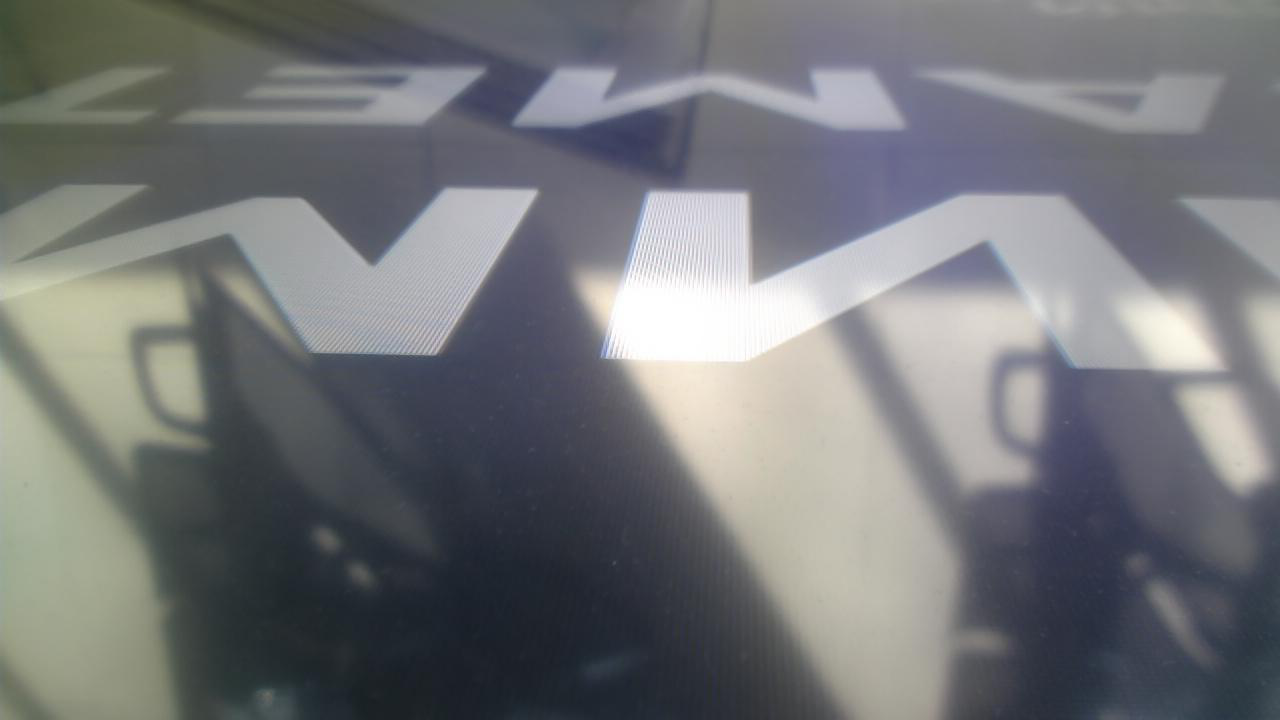

In [160]:
from PIL import Image

im = Image.open(shit_images[6])
im

In [37]:
problematic = shit_images

In [47]:
len(problematic)

271